## Text Clustering

In this notebook we use BERTweet to encode all tweets, use PCA to reduce their dimensions, and use KMeans to cluster them into 15 topics. 

In [2]:
import pandas as pd
import glob
import warnings
warnings.filterwarnings('ignore')
from pandarallel import pandarallel
pandarallel.initialize()

data_dir = "../data/final/"
files = sorted(glob.glob(f"{data_dir}*.csv"))
files

INFO: Pandarallel will run on 48 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


['../data/final/hcq.csv',
 '../data/final/ivermectin.csv',
 '../data/final/molnupiravir.csv',
 '../data/final/remdesivir.csv']

In [3]:
dfs = [pd.read_csv(file) for file in files] 
drugs = [d.split("/")[-1].split(".")[0] for d in files]
drugs

['hcq', 'ivermectin', 'molnupiravir', 'remdesivir']

## Embed tweets

In [3]:
import numpy as np
import torch
from sentence_transformers import SentenceTransformer


model_name = 'digitalepidemiologylab/covid-twitter-bert'
#@param ["digitalepidemiologylab/covid-twitter-bert", "bert-large-uncased", "bert-base-uncased"]
model = SentenceTransformer(model_name)

Some weights of the model checkpoint at /mnt/hdd/ningh/.cache/torch/sentence_transformers/digitalepidemiologylab_covid-twitter-bert were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Before clustering let's mask the user names and calculate the embeddings. 
This takes some time.

In [4]:
import re

def desensitize(text):
    text = ' '.join(re.sub("([@#][A-Za-z0-9_]+)|(\w+:\/\/\S+)","@USER", text).split())
    return text

In [7]:
import torch

for DRUG, df in zip(drugs,dfs):
    # df["desensitized_text"] = df.full_text.parallel_apply(lambda x: desensitize(x))
    sentences = df.full_text

    embeddings = model.encode(sentences,show_progress_bar=True)
    embeddings.shape
    x = torch.tensor(embeddings)
    torch.save(x, f'embeddings/{DRUG}.pt')

In [5]:
# # get backend toolkit code
# !wget https://public-thought.media.mit.edu/static/ccc_toolkit_v_21_0.py

# # get emotions lexicon
# !wget https://saifmohammad.com/WebDocs/Lexicons/NRC-Emotion-Lexicon.zip
# !unzip NRC-Emotion-Lexicon.zip

# Download and load data (this is going to take a couple of minutes.)
from ccc_toolkit_v_21_0 import (
                          plot_tsne_viz,
                          run_clustering,
                          reduce_dimensionality,
                          retrieve,
                          SentenceTransformer)

In [9]:
drugs

['hcq', 'ivermectin', 'molnupiravir', 'remdesivir']

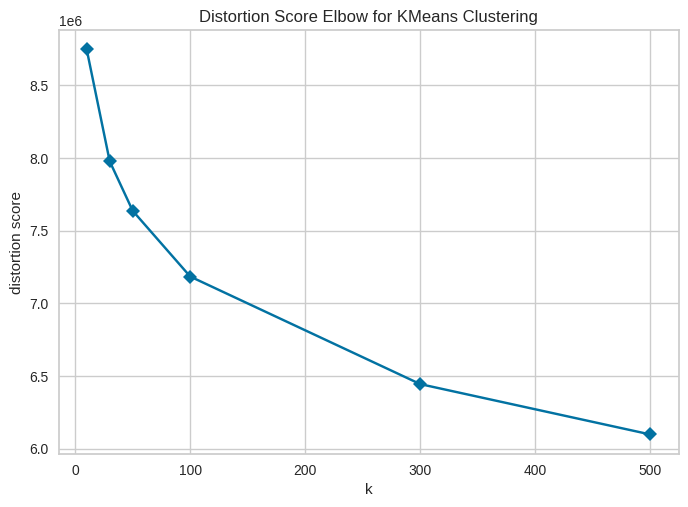

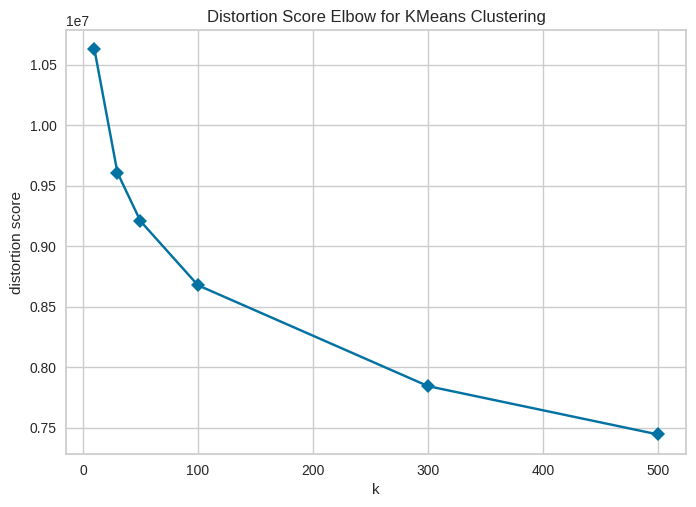

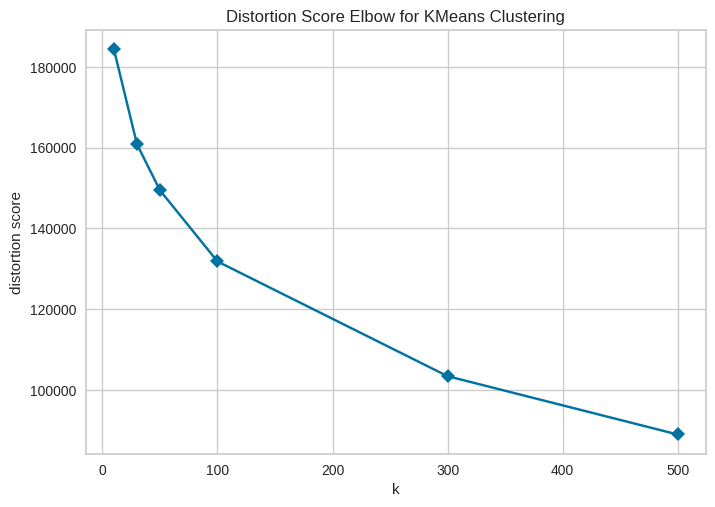

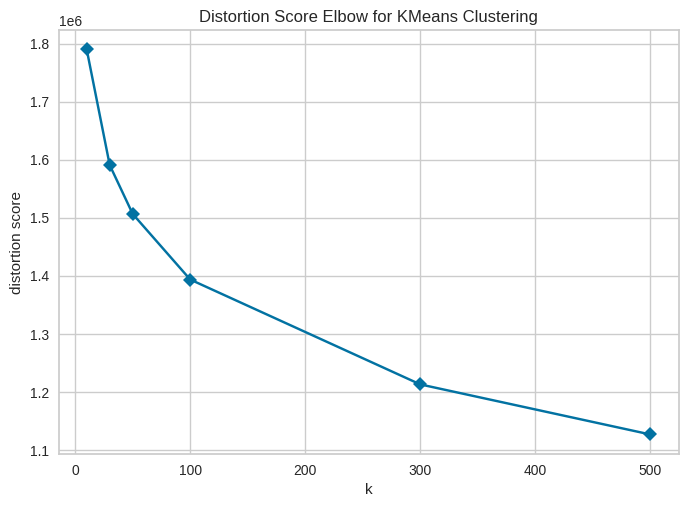

In [8]:
import torch
from sklearn.cluster import KMeans

from yellowbrick.cluster import KElbowVisualizer


for drug in drugs:
    X = torch.load(f'embeddings/{drug}.pt').numpy()
    # Instantiate the clustering model and visualizer
    model = KMeans()
    visualizer = KElbowVisualizer(model,k=(10, 30, 50, 100, 300, 500), locate_elbow=False, timings=False)
    visualizer.fit(X)        # Fit the data to the visualizer
    visualizer.show()        # Finalize and render the figure


## Clustering
We'll load the embeddings and run the clustering

In [24]:
"""
Every time you run this cell you'll get different clusters and embeddings
due to the fact that these methods calculate approximate transformations
that depend on the initial random seed.
"""

N_TOPICS = 15

import torch

def viz_cluster(df, pca_components=30, n_clusters=N_TOPICS):
    sub_df = df
    utt = sub_df.full_text.tolist()
    emb = torch.from_numpy(np.concatenate(sub_df.embeddings.values).reshape(len(sub_df),1024))
    print("Sampled data contains {} utterances.".format(len(emb)))

    reduced_embeddings = reduce_dimensionality(emb)
    viz_coord, centers, predictions, _, _ = run_clustering(utt,
                                                            pca_components=pca_components,
                                                            k_clusters=n_clusters,
                                                            embeddings=reduced_embeddings)
    # plot_tsne_viz(viz_coord, utt,
    #                 clusters = predictions, 
    #                 # centers = sub_df.center.tolist(),
    #                 coloring='clusters',
    #                 # labels = sub_df.med.tolist(),
    #                 title="%i-means clusters."%n_clusters)
    return centers

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 1024, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)

In [17]:
import os
os.makedirs("clusters_negative/",exist_ok=True)

In [19]:
## This divides each drug into 3 waves. But we found that people's rationale barely change across 3 waves, so we removeed it.
# for i, drug in enumerate(drugs):
#     print("On %s"%drug)
#     embeddings = torch.load(f"embeddings/{drug}.pt")
#     print(embeddings.shape)
#     df = dfs[I]
#     # df["desensitized_text"] = df.full_text.parallel_apply(lambda x: desensitize(x))

#     df["embeddings"] = [np.array(e) for e in embeddings]
#     df = df[df.stance==-1]
#     df["lower"] = df.desensitized_text.str.lower()
#     df = df.drop_duplicates(subset=['lower'])
#     df.pop("lower")

#     w1, w2, w3 = df[df.wave==1], df[df.wave==2], df[df.wave==3]
#     m = 1 
#     for w in [w1, w2, w3]:
#         if len(w) < N_TOPICS*3:
#             print("Too few tweets. Skipping...")
#             continue
#         w = w.reset_index(drop=True)
#         # df_cent = center_df[(center_df.drug==drug)&(center_df.wave==m)]
#         emb = torch.from_numpy(np.concatenate(w.embeddings.values).reshape(len(w),1024))
#         center_idx = viz_cluster(w)
#         df_cent = w.iloc[center_idx]["desensitized_text"].reset_index(drop=True)
#         ## find similar 15 tweets in the pool of that drug, that time window
#         # print("Start retrieving")
#         emb = emb.to(device)

#         w_similar_df = retrieve(model, df_cent.values, w.desensitized_text, emb, closest_n=30)
#         w_similar_df.to_csv(f"clusters_negative/{drug}_wave{m}_cluster.csv",index=False)
#         m += 1


In [26]:
for i, drug in enumerate(drugs):
    print("On %s"%drug)
    embeddings = torch.load(f"embeddings/{drug}.pt")
    print(embeddings.shape)
    df = dfs[i]
    # df["desensitized_text"] = df.full_text.parallel_apply(lambda x: desensitize(x))
    df["embeddings"] = [np.array(e) for e in embeddings]
    df = df[df.stance==-1]
    df["lower"] = df.desensitized_text.str.lower()
    df = df.drop_duplicates(subset=['lower'])
    df.pop("lower")

    w = df.reset_index(drop=True)
    emb = torch.from_numpy(np.concatenate(w.embeddings.values).reshape(len(w),1024))
    center_idx = viz_cluster(w)
    df_cent = w.iloc[center_idx]["desensitized_text"].reset_index(drop=True)
    ## find similar 15 tweets in the pool of that drug, that time window
    # print("Start retrieving")
    emb = emb.to(device)

    w_similar_df = retrieve(model, df_cent.values, w.desensitized_text, emb, closest_n=30)
    w_similar_df.to_csv(f"clusters_negative/{drug}_cluster.csv",index=False)